# Osatuletistega diferentsiaalvõrrandid

<div style="float: left;">Valter Kiisk<br><span style="font-size: 75%;">TÜ Füüsika Instituut</span></div><div style="float: right;">Viimati muudetud: 31.03.2018</div>
<div style="display:none">
$\renewcommand{\vec}{\boldsymbol}$
$\newcommand{\erf}{\mathop{\rm erf}\nolimits}$
$\newcommand{\mod}{\mathop{\rm mod}\nolimits}$
</div>

In [2]:
# üldised vahendid ja seadistused
import numpy as np
from numpy import linspace, arange, exp, sin, cos, log, sqrt, pi
from scipy.special import expit
from scipy.sparse import spdiags, csc_matrix, identity as spident
from scipy.sparse.linalg import spsolve
from matplotlib.pyplot import *
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['lines.markeredgewidth'] = 0
rcParams['lines.markersize'] = 5
rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'small'

## Soojusjuhtivusvõrrand ja selle numbriline lahendamine

Vaatleme homogeenset varrast pikkusega $L$ (mida käsitleme ühemõõtmelise objektina). Tähistagu $u(x, t)$ varda temperatuuri punktis koordinaadiga $x$ ajahetkel $t$. Alghetkel on teada temperatuur kõikjal piki varrast: $u(x,0)=u_0(x)$. Samuti on fikseeritud ääretingimused otspunktides $x=a$ ja $x=b$. Kui varras on valmistatud hea soojusjuhtivusega materjalist, siis soojuskadusid läbi varda külgpinna võib ignoreerida ja temperatuuri arengut kirjeldab ühemõõtmeline [soojusjuhtivusvõrrand](https://en.wikipedia.org/wiki/Heat_equation): $$\frac{\partial u}{\partial t}=D\frac{\partial^2 u}{\partial x^2}.$$ Siin difusioonikonstant $D$ on kombinatsioon materjali soojusjuhtivustegurist $k$, erisoojusest $c$ ja tihedusest $\rho$: $D=k/(c\rho)$. Selline ühemõõtmeline võrrand koos alg- ja ääretingimustega on võimalik analüütiliselt lahendada muutujate eraldamise ja Fourier' analüüsi võtetega, kuid vastus avaldub üldjuhul lõpmatu rea kujul, seetõttu on õigustatud ka numbriline lahendamine.

Osatuletistega võrrandi numbrilise lahendi saab ilmselt anda vaid lõpliku sammuga võrgustiku sõlmedes. Seega jagame varda $n+1$ võrdse pikkusega osaks, nii et sisemisi sõlmi on $n$ tükki ja koos otspunktidega saame kokku $n+2$ punkti koordinaatidega $x_i=a+i\Delta x$, kus $\Delta x=L/(n+1)$. Vastavad temperatuuriväärtused sõlmedes tähistame $u_i$. Lihtsaim sümmeetriline [diferentsvalem](integ.html) 2. tuletise aproksimeerimiseks sellise võrgustiku sõlmedes on järgmine: $$\left(\frac{\partial^2 u}{\partial x^2}\right)_{x=x_i}\approx \frac{u_{i+1}-2u_i+u_{i-1}}{\Delta x^2}.$$ Kui kõigi sisemiste sõlmede temperatuurid võtta kokku ühte vektorisse $\vec u$, siis $\partial^2 \vec u/\partial x^2$ ja seega ka $\partial \vec u/\partial t$ avaldub maatrikskujul $\vec A\vec u+\vec b$, kus $\vec A$ on $n\times n$ maatriks ja $\vec b$ on vektor pikkusega $n$. Nende täpne sisu sõltub ääretingimustest, nagu kirjeldatakse edaspidi.

Niisiis oleme algse võrrandi asemel saanud harilike diferentsiaalvõrrandite süsteemi $d\vec u/dt=\vec A\vec u+\vec b$, mis tuleb lahendada mõnesuguse ajasammuga $\Delta t$. Iga ajahetke $t_s=s\Delta t$ jaoks saame varda temperatuuriprofiili $\vec u_s$. Süsteemi $d\vec u/dt=\vec A\vec u+\vec b$ lahendamiseks võib kasutada mõnda algoritmi moodulist `scipy.integrate`. Vaatame siin alternatiivset lahendust, mis tugineb asjaolule, et tegemist on lineaarse diferentsiaalvõrrandite süsteemiga. Tuntud ilmutamata meetod harilike diferentsiaalvõrrandite lahendamiseks on [trapetsmeetod](https://en.wikipedia.org/wiki/Trapezoidal_rule_%28differential_equations%29), mis on numbriliselt stabiilne ja sobilik ka jäikade süsteemide jaoks. Antud kontekstis nimetatakse seda [Crank–Nicolsoni meetodiks](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) ja see omandab kuju:
$$\vec{u}_{s+1}\approx \vec{u}_s + \frac{1}{2}\left(\vec{A}\vec{u}_{s+1}+\vec{A}\vec{u}_s\right)\Delta t+\vec b\Delta t.$$
Siit järeldub lineaarne algebraline võrrandisüsteem vektori $\vec{u}_{s+1}$ määramiseks: $$\left(\vec I-\frac{\Delta t}{2}\vec A\right)\vec{u}_{s+1}=\left(\vec I+\frac{\Delta t}{2}\vec A\right)\vec{u}_s+\vec b\Delta t,$$ kus $\vec I$ on $n\times n$ ühikmaatriks. Kõik mainitud diagonaalmaatriksid on [hõredad](https://en.wikipedia.org/wiki/Sparse_matrix) (eriti kui $n$ on suur) ja mõistlik on kasutada vahendeid moodulist `scipy.sparse`. Sealt saab spetsiaalsed andmestruktuurid, kus nii arvutuskiiruse kui ka mälunõudluse optimeerimise eesmärgil säilitatakse vaid nullist erinevad maatriksi elemendid.

## Dirichlet' ääretingimused

Esmalt vaatleme lihtsamat juhtu, kus väliselt kontrollitakse varda otspunktide temperatuure, st $u_a(t)$ ja $u_b(t)$ on teadaolevad aja funktsioonid. Sel juhul  $$\vec A = \frac{D}{\Delta x^2} \begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 & 0 & 0 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2\end{bmatrix},\quad \vec b=\frac{D}{\Delta x^2} \begin{bmatrix}u_a\\0\\ \vdots \\ 0 \\ u_b\end{bmatrix}$$

Esmalt veendume, et saame `scipy.sparse.spdiags` abil õige sisuga maatriksi (arvestamata esialgu tegurit $D/\Delta x^2$):

In [3]:
n = 100  # sisemiste sõlmede arv
ones = np.ones(n)
A = spdiags((-2*ones, ones, ones), (0,1,-1), n, n, format='csc')
A.toarray()

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

Edasi defineerime vajalikud kvantiteedid ja korrutame maatriksi teguriga $D/\Delta x^2$:

In [4]:
L = 1         # varda pikkus
Δx = L/(n+1)  # võrgustiku samm
D = 1         # difusioonikonstant
A *= D/Δx**2

Hõreda ühikmaatriksi defineerime analoogiliselt `scipy.sparse.identity` abiga ja ülejäänud maatriksid saab juba maatriksarvutuse operatsioonidega:

In [5]:
Δt = 0.0005   # ajasamm
δ = Δt / 2
I = spident(n, format='csc')
A1 = I - δ*A
A2 = I + δ*A

Realistlikkuse ja arvutuse numbrilise stabiilsuse huvides eeldame, et varda otspunktide temperatuur ei kuku mitte hetkega nulli, vaid sujuvalt, nagu kirjeldab näiteks [logistiline funktsioon](https://en.wikipedia.org/wiki/Logistic_function) (`scipy.special.expit`):

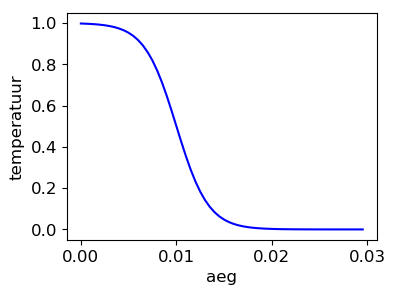

In [6]:
r = lambda t: 1 - expit(600*(t - 0.01))

figure(figsize=(4,3))
t = arange(0, 0.03, Δt)
plot(t, r(t), 'b-')
xlabel('aeg')
ylabel('temperatuur')
show()

Nüüd saab võrrandisüsteemi lahendada:

In [7]:
u = np.ones(n)    # algtingimus
lahend = [u]

steps = 500  # arvutame 500 ajasammu
for i in range(steps):
    ua = ub = r(i*Δt)  # ääretingimused
    b = (D/Δx**2) * csc_matrix(( (ua, ub), ((0, n-1), (0, 0)) ))
    u = spsolve( A1, A2*csc_matrix(u).T + b*Δt )
    lahend.append(u)

Kõik 500 lahendit erinevate ajahetkete jaoks on nüüd kogutud järjendisse `lahend`. Nende hulgast tuleb teha mõnesugune valik, et jälgida temperatuuriprofiili ajalist arengut.

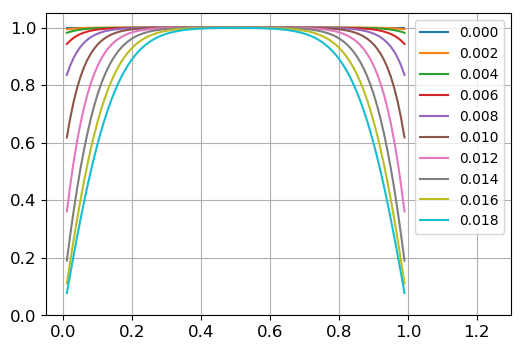

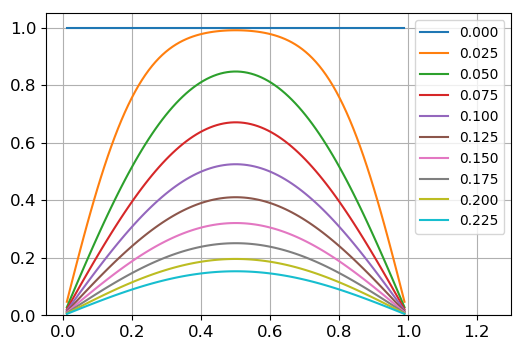

In [8]:
x = linspace(0, L, n+2)[1:-1]

def graafik(*args):
    for s in range(*args):
        if s < steps:
            plot(x, lahend[s], label='%.3f' % (s*Δt))

    xlim(-0.05, 1.3)
    ylim(0, 1.05)
    grid()
    legend(loc=1)
    show()

graafik( 0, 40, 4 )
graafik( 0, 500, 50 )

Seda tüüpi ajalist sõltuvust on loomulik kirjeldada animatsiooniga. Kui kasutada `%matplotlib inline` (vaikimisi) asemel `%matplotlib notebook`, saame interaktiivse graafiku otse Jupyteri keskkonnas. Lihtne liides graafiku animeerimiseks on `matplotlib.animation.FuncAnimation`.

<IPython.core.display.Javascript object>


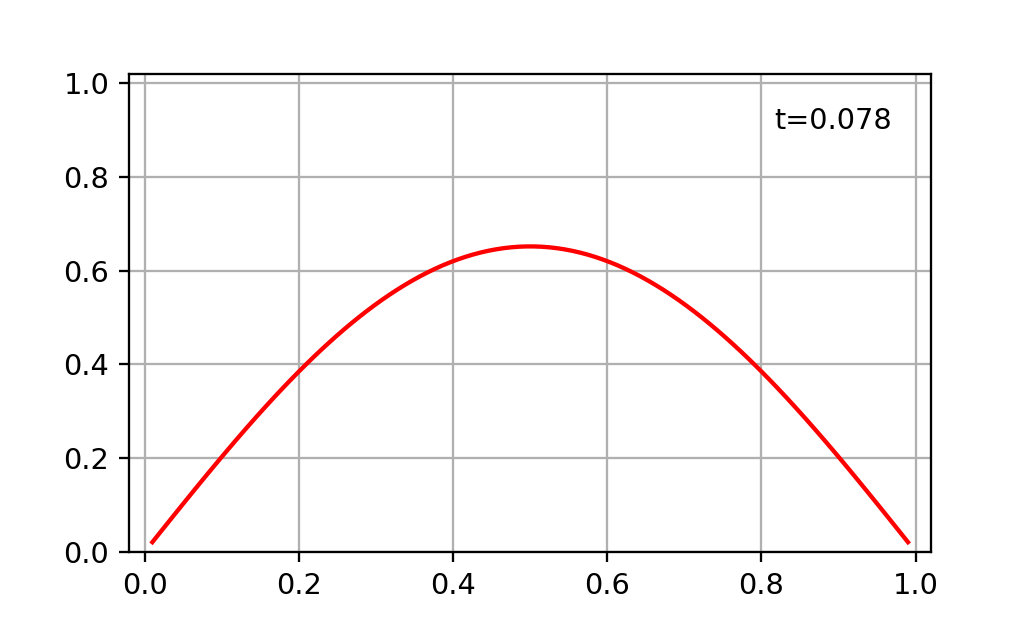

In [12]:
%matplotlib notebook

graafik = figure(figsize=(5,3))
joon, = plot( (), (), 'r-')
aeg = text(0.97, 0.95, '', ha='right', va='top')
xlim(-0.02, 1.02)
ylim(0, 1.02)
grid()

def uuenda(kaader):
    s = 2*kaader
    joon.set_data(x, lahend[s])
    aeg.set_text( 't=%.3f' % (s*Δt) )
    return joon, aeg

ani = FuncAnimation(graafik, uuenda, frames=250, interval=100, blit=True)
show()

## Neumanni ääretingimused

Lahendame nüüd samalaadse ülesande kui varda otspunktid on soojuslikult isoleeritud. Seega soojusvoog ehk temperatuurigradient on otspunktides võrdne nulliga. Temperatuurigradiendi ehk 1. tuletise arvutamiseks otspunktis $a$ tuleb kasutada ilmselt diferentsvalemit sammuga ette (jällegi 2. järku täpsusega valem): $$\left(\frac{\partial u}{\partial x}\right)_{x=a}\approx \frac{-3u_a+4u_1-u_2}{2\Delta x}=0,$$ millest $u_a=\frac{4}{3}u_1-\frac{1}{3}u_2$. Analoogiliselt leiame $u_b=\frac{4}{3}u_n-\frac{1}{3}u_{n-1}$. Seega selliste ääretingimuste korral võime võtta $$\vec A = \frac{D}{\Delta x^2} \begin{bmatrix}
-2/3 & 2/3 & 0 & \cdots & 0 & 0 & 0 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 \\
0 & 0 & 0 & \cdots & 0 & 2/3 & -2/3\end{bmatrix},\quad \vec b=\vec 0.$$ Muus osas on arvutuskäik endine:

In [14]:
A = spdiags((-2*ones, ones, ones), (0,1,-1), n, n, format='csc')
A[0, 0] = -2/3
A[0, 1] = 2/3
A[-1, -1] = -2/3
A[-1, -2] = 2/3
A *= D/Δx**2
A1 = I - δ*A
A2 = I + δ*A

u = 2*np.exp(-50*(x-L/2)**2)     # algtingimus
lahend = [u]
for i in range(steps):
    u = spsolve( A1, A2*u )
    lahend.append(u)

<IPython.core.display.Javascript object>


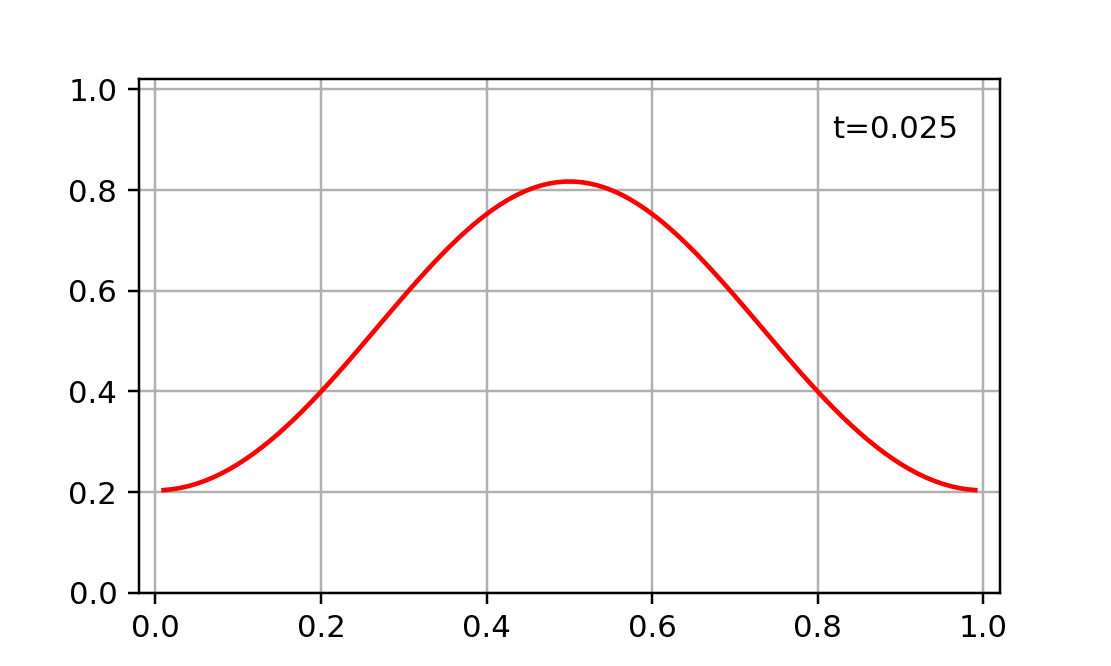

In [15]:
%matplotlib notebook

graafik = figure(figsize=(5,3))
joon, = plot( (), (), 'r-')
aeg = text(0.97, 0.95, '', ha='right', va='top')
xlim(-0.02, 1.02)
ylim(0, 1.02)
grid()

def uuenda(kaader):
    s = 2*kaader
    joon.set_data(x, lahend[s])
    aeg.set_text( 't=%.3f' % (s*Δt) )
    return joon, aeg

ani = FuncAnimation(graafik, uuenda, frames=250, interval=100, blit=True)
show()